# Trabajo Práctico 2 de Visión por Computadora I
## Laboratorio de Sistemas Embebidos - FIUBA
## Integrantes:
- Federico Arias
- Hernán Matías Silva

1.- Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "ImageSharpnessMeasureforBlurredImagesin FrequencyDomain“ y realizar tres experimentos: 
- 1. Medición sobre todo el frame. 
- 2. Medición sobre una ROI ubicada en el centro del frame. Areade la ROI = 5 o 10% del areatotal del frame. 
- 3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxMelementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc… (al menos 3)

2.- Cambiar la métrica de enfoque, eligiendo uno de los algoritmos explicados en el apéndice de Analysis of focus measure operators in shapefrom focus

In [1]:
import numpy as np
from scipy.fft import fft2, fftshift
import cv2
import matplotlib.pyplot as plt

In [2]:
#Creamos un funcion que cumpla con lo descrito en el paper Image Sharpness Measure for Blurred Images in Frequency Domain
def get_sharpness_measurement(image):
    
    #El paper indica los siguientes pasos para obtener la metrica de nitidez (FM), se deben aplicar los siguientes pasos:

    # Paso 1: Calcular la transformada de Fourier a la imagen
    F = fft2(image)
    
    # Paso 2: Centrar la transformada
    Fc = fftshift(F)
    
    # Paso 3: Calcular el valor absoluto
    AF = np.abs(Fc)
    
    # Paso 4: Obtener el valor máximo de los componentes de frecuencia
    M = np.max(AF)
    
    # Paso 5: Definir el umbral
    threshold = M / 1000
    
    # Paso 6: Contar los píxeles mayores que el umbral
    high_freq_count = np.sum(AF > threshold)
    
    # Paso 7: Calcular la focus measurement
    FM = high_freq_count / image.size
    
    return FM

<h2 style='color:orange;'> 1.1 Medición sobre todo el frame</h2>

El valor de Focus measurement para la imagen desenfocada es: 0.11117476851851851


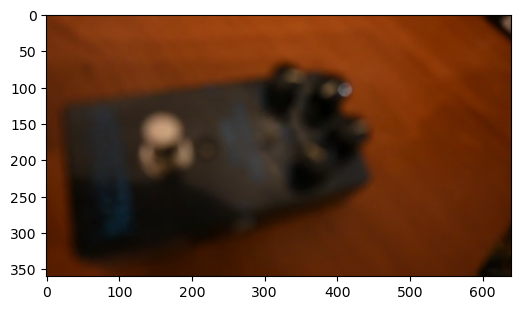

In [3]:
#Probamos el algoritmo con una imagen desenfocada:
#Vamos a obtener el frame desenfocado desde el video:
video = cv2.VideoCapture('focus_video.mov')

# La seccion de desenfoque es al principio y al final, tomamos la del ppio.
# Establecemos el número 5 del frame
frame_number = 5  
video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Captura el frame
ret, unfocused_image = video.read()

unfocused_image = cv2.cvtColor(unfocused_image, cv2.COLOR_BGR2RGB) 

# Aplicar el cálculo a toda la imagen
FM_total = get_sharpness_measurement(unfocused_image)

plt.figure(figsize=(6,6))
plt.imshow(unfocused_image)
print('El valor de Focus measurement para la imagen desenfocada es:', FM_total)

El valor de Focus measurement para la imagen desenfocada es: 0.278314525462963


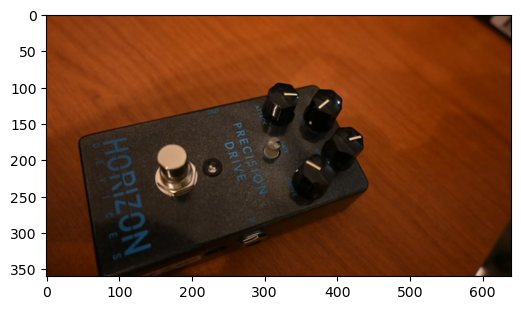

In [4]:
#Probamos el algoritmo con una imagen enfocada:
# Ahora usaremos el frame 110 para una imagen enfocada
frame_number = 110 
video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Captura el frame
ret, focused_image = video.read()

focused_image = cv2.cvtColor(focused_image, cv2.COLOR_BGR2RGB)

# Aplicar el cálculo a toda la imagen
FM_total = get_sharpness_measurement(focused_image)
plt.figure(figsize=(6,6))
plt.imshow(focused_image)

print('El valor de Focus measurement para la imagen desenfocada es:', FM_total)

#Soltamos el objeto para poder tomarlo luego y hacer las iteraciones en el video
video.release()

Vemos que el algoritmo funciona, ya que la imagen enfocada (0.278) tiene aproximadamente el doble de Focus Measurement que la imagen sin enfocar (0.11)

In [5]:
#Ahora calculamos la metrica para cada frame del video:

# leemos el video
video = cv2.VideoCapture('focus_video.mov')

# Comprobamos si el video se abrió correctamente
if not video.isOpened():
    print("Error al abrir el video")
    exit()

#Definimos una lista para almacenar los resultados de FM
resultados = []

# Leemos el video frame por frame
while True:
    ret, frame = video.read()
    
    # Si no hay más frames, salir del bucle
    if not ret:
        break
    
    # Aplicamos FM al a cada frame
    valor = get_sharpness_measurement(frame)
    
    # Almacenamos el resultado
    resultados.append(valor)
    
    # Salimos si se presiona 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Soltamos el objeto de video y cerrar las ventanas
video.release()
cv2.destroyAllWindows()

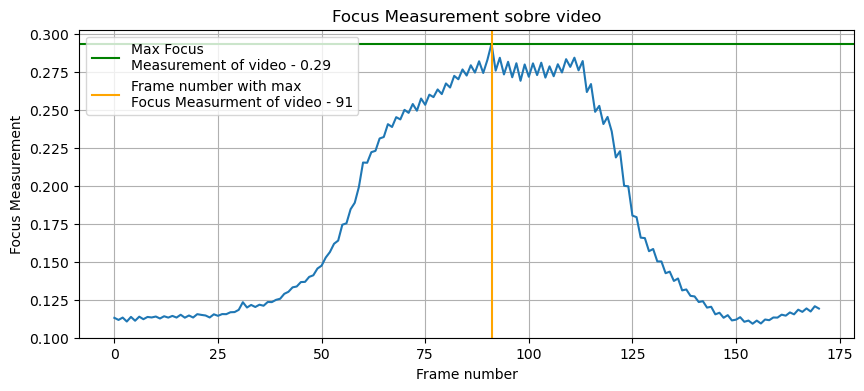

In [6]:
#Graficamos el FM a lo largo de cada frame del video:
plt.figure(figsize=(10,4))
plt.plot(resultados)
plt.title('Focus Measurement sobre video')
plt.grid()
plt.xlabel('Frame number')
plt.ylabel('Focus Measurement')
plt.axhline(max(resultados), color='green', label=f'Max Focus \nMeasurement of video - {max(resultados):.2f}')
plt.axvline(resultados.index(max(resultados)), color='orange', 
            label=f'Frame number with max\nFocus Measurment of video - {resultados.index(max(resultados))}')
plt.legend()

<h2 style='color:orange;'> 1.2. Medición sobre una región de interés (ROI)</h2>

In [7]:
#Vamos a hacer una funcion que nos entregue las coordenadas de la roi centrada
#segun un porcentaje de altura y width

def get_roi(height, width, height_percentage, width_percentage, corroborar=False):
    '''Creamos una funcion para obtener la roi en el video
    Segun las dimensiones del video
    
    height: int : es la altura del video
    weight: int : es el ancho del video
    height_percentage: float : porcentaje de altura de la roi sobre la altura del frame
    width_percentage: float : porcentaje de largo de la roi sobre el largo del frame
    corroborar=False -> para obtener el area de la roi dividida el area total del frame
    '''

    # Calcular el centro
    center_x = width // 2
    center_y = height // 2

    #Ademas obtenemos las dimensiones de la ROI como el 10% de la imagen:
    M = width_percentage * height
    N = height_percentage * width

    #Ahora definimos la ROI:
    roi_left = round(center_x - N/2)
    roi_right = round(center_x + N/2)

    roi_up = round(center_y + M/2)
    roi_down = round(center_y - M/2)

    #Corroboramos:
    if corroborar:
        print('El porcentaje de la nueva ROI sobre el area total es de:', (M*N) / (height*width))

    return roi_left, roi_right, roi_up, roi_down

In [8]:
height, width = focused_image.shape[:2]
get_roi(height, width, 0.25, 0.3, corroborar=True)  #Con M=0.25 y N=0.3 obtenemos un 7.5% del area total, valor dentro de 5 y 10% que pide el enunciado 

El porcentaje de la nueva ROI sobre el area total es de: 0.075


(240, 400, 234, 126)

Text(0.5, 1.0, 'ROI a aplicar el focus measurement en el video')

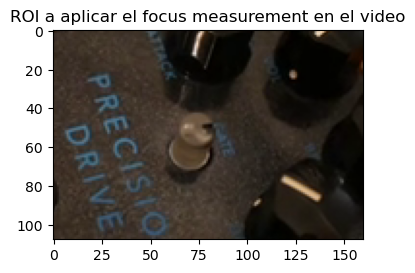

In [9]:
#Veamos la ROI para un frame

height, width = focused_image.shape[:2]

roi_left, roi_right, roi_up, roi_down = get_roi(height, width, 0.25, 0.3, corroborar=False)

plt.figure(figsize=(4,4))
plt.imshow(focused_image[roi_down:roi_up, roi_left:roi_right])
plt.title('ROI a aplicar el focus measurement en el video')

In [10]:
#Definimos la lista para guardar los valores de FM:
roi_results = []

# Leemos el video
video = cv2.VideoCapture('focus_video.mov')

#Definimos un threshold para que el rectangulo cambie a color verde
#Indicando que el frame esta enfocado
threshold = 0.65

# Comprobar si el video se abrió correctamente
if not video.isOpened():
    print("Error al abrir el video")
    exit()

while True:
    ret, frame = video.read()
    
    # Si no hay más frames, salir del bucle
    if not ret:
        break
    #print(frame.shape)

    # Obtener las dimensiones del frame
    height, width = frame.shape[:2]
    
    #Definimos la roi a la cual calcular la FM:
    roi_left, roi_right, roi_up, roi_down = get_roi(height, width, 0.25, 0.3, corroborar=False)
    
    #Subseteamos el frame original con la roi
    roi_frame = frame[roi_down:roi_up, roi_left:roi_right]
    
    # Aplicar tu función al roi
    FM = get_sharpness_measurement(roi_frame)
    
    # Almacenar el resultado
    roi_results.append(FM)
    
    #Agregamos el rectangulo con el color que depende del valor del enfoque:
    if FM >= threshold:
        cv2.rectangle(frame, (roi_left, roi_up), (roi_right, roi_down), (0, 255, 0), 4, cv2.LINE_AA)
    else: 
        cv2.rectangle(frame, (roi_left, roi_up), (roi_right, roi_down), (0, 0 ,255), 4, cv2.LINE_AA)
    #Mostramos la roi:
    cv2.imshow('ROI', frame)

    # Salir si se presiona 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar el objeto de video y cerrar las ventanas
video.release()
cv2.destroyAllWindows()

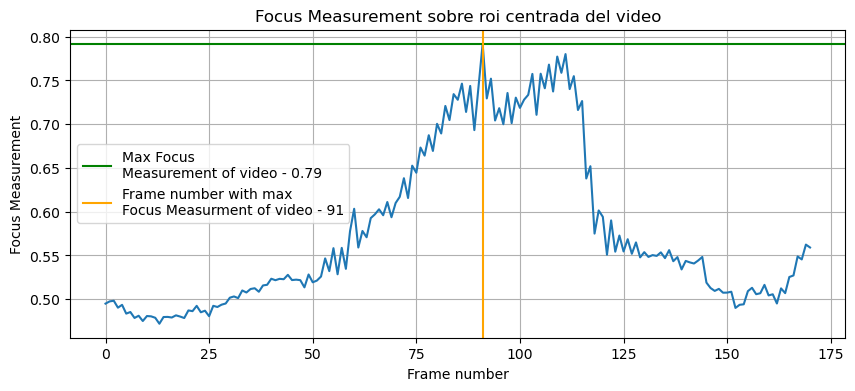

In [11]:
#Graficamos el FM sobre cada frame
plt.figure(figsize=(10, 4))
plt.plot(roi_results)
plt.title('Focus Measurement sobre roi centrada del video')
plt.grid()
plt.xlabel('Frame number')
plt.ylabel('Focus Measurement')
plt.axhline(max(roi_results), color='green', label=f'Max Focus \nMeasurement of video - {max(roi_results):.2f}')
plt.axvline(roi_results.index(max(roi_results)), color='orange', 
            label=f'Frame number with max\nFocus Measurment of video - {roi_results.index(max(roi_results))}')
plt.legend()

Notamos que el Focus Measurement sobre la ROI del centro del video, es distina a la del video completo.
- El focus Measurement máximo pasó de 0.29 a 0.79.
- Curiosamente el frame al cual se obtuvo el FC maximo se mantuvo en 91.

<h2 style='color:orange;'> 1.3 Medición sobre una matriz de enfoque compuesta por un arreglo de NxM</h2>

Se entiende que ahora la roi no es un cuadrado centro del video, sino una matriz de NxM a definir centrada en el video.

In [12]:
#Definimos funcion que toma como argumentos el tamanho del espacio ocupado por la matriz,
# las dimensiones nxm, el tamanho de los cuadrados en la matriz y el espacio entre cuadrados
# devuelve 
def get_focus_matrix(height, width, n, m, component_size=50, interspace=10):
    '''
    height: altura de los frames del video
    widht: largo de los frames del video
    n: dimension x de la matriz
    m: dimension y de la matriz
    component_size: tamaño de cada bloque o componente dentro de la matriz
    interspace: tamaño del interespaciado entre bloques dentro de la matriz
    '''
    #Obtenemos la region dentro de la imagen que representa a la matriz, 
    #La matriz esta compuesta por bloques e interespacios entre bloques
    matrix_width = m * (component_size + interspace) - interspace
    matrix_height = n * (component_size + interspace) - interspace
    
    start_x = (width - matrix_width) // 2
    start_y = (height - matrix_height) // 2
    
    components = []
    #Armamos los bloques y los interespacios dentro de la matriz de enfoque
    for i in range(n):
        for j in range(m):
            x = start_x + j * (component_size + interspace)
            y = start_y + i * (component_size + interspace)
            components.append((x, y, x + component_size, y + component_size))
    
    return components

In [13]:
#Esta funcion aplica el FM a la matriz de enfoque

def get_focusMeasurement_per_matrix(video, n, m, component_size, interspace, threshold):
    '''
    video: objeto video de cv2.VideoCapture()
    n: dimension x de la matriz
    m: dimension y de la matriz
    component_size: tamaño de cada bloque o componente dentro de la matriz
    interspace: tamaño del interespaciado entre bloques dentro de la matriz
    threshold: umbral que define cuando esta enfocado o no.
    '''
    #Guardamos una métrica para comparar entre iteraciones de tamnhos de matriz.
    #Cuantos frames pasan el threshold
    focused_frames = 0
    
    # Comprobar si el video se abrió correctamente
    if not video.isOpened():
        print("Error al abrir el video")
        exit()

    # Leer el primer frame para obtener las dimensiones
    ret, frame = video.read()
    if not ret:
        print("Error al leer el primer frame")
        exit()
    
    #Creamos la matriz de enfoque, sus bloques y el interespaciado
    height, width = frame.shape[:2]
    components = get_focus_matrix(height, width, n, m, component_size, interspace)

    while True:
        ret, frame = video.read()
        
        if not ret:
            break

        # Crear una copia del frame para dibujar encima
        overlay = frame.copy()

        # Lista para almacenar los valores de FM de cada componente
        fm_values = []

        for x1, y1, x2, y2 in components:
            # Extraer el componente
            component = frame[y1:y2, x1:x2]
            
            # Calcular el FM para este componente
            fm = get_sharpness_measurement(component)
            fm_values.append(fm)
        
        # Calcular el promedio de FM para toda la matriz para ese frame
        average_fm = np.mean(fm_values)
        
        # Determinar el color basado en si el promedio supera el threshold
        color = (0, 255, 0) if average_fm >= threshold else (0, 0, 255)
        focused_frames += 1 if average_fm >= threshold else 0
        
        # Dibujar todos los componentes con el mismo color
        for x1, y1, x2, y2 in components:
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, -1)
        
        # Combinamos el frame original con el overlay
        result = cv2.addWeighted(overlay, 0.4, frame, 0.6, 0)
        
        # Mostramos el valor promedio de FM en el frame
        cv2.putText(result, f"Avg FM: {average_fm:.2f}", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
        # Mostrar el resultado
        cv2.imshow('Matriz de enfoque promedio', result)
        

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    print('Total frames enfocados:', focused_frames)        
    video.release()
    cv2.destroyAllWindows()

    return focused_frames

1.3.1 Hacemos la matriz de enfoque para una matriz de 4x5

In [14]:
# Definir parámetros
n, m = 4, 5  # Dimensiones de la matriz
component_size = 8  # Tamaño de cada componente en píxeles
interspace = 15  # Espacio entre componentes
threshold = 0.9  # Ajusta este valor según tu método de medición de nitidez
# Abrir el video
video = cv2.VideoCapture('focus_video.mov')

get_focusMeasurement_per_matrix(video, n, m, component_size, interspace, threshold)

Total frames enfocados: 57


57

1.3.2 Hacemos la matriz de enfoque para una matriz de 7x6

In [15]:
n, m = 7, 6  # Dimensiones de la matriz
threshold = 0.9 # Ajusta este valor según tu método de medición de nitidez
video = cv2.VideoCapture('focus_video.mov')

get_focusMeasurement_per_matrix(video, n, m, component_size, interspace, threshold)

Total frames enfocados: 34


34

1.3.3 Hacemos la matriz de enfoque para una matriz de 9x12

In [16]:
n, m = 9, 12  # Dimensiones de la matriz
threshold = 0.9  # Ajusta este valor según tu método de medición de nitidez
video = cv2.VideoCapture('focus_video.mov')

get_focusMeasurement_per_matrix(video, n, m, component_size, interspace, threshold)

Total frames enfocados: 15


15

Podemos notar que para un mismo threshold, tamaño de bloque (component size), interespaciado entre bloques, si variamos el tamanho de la matriz de enfoque, la cantidad de frames enfocados será inferior mientras más grande la matriz en enfoque definida.

- Tamaño Matriz: 4x5 -> Cantidad de frames enfocados: 57 
- Tamaño Matriz: 7x6 -> Cantidad de frames enfocados: 34
- Tamaño Matriz: 9x12 -> Cantidad de frames enfocados: 15

In [17]:
#Vamos a correr un loop para ver la cantidad de frames enfocados cuando variamos el tamanho de la matriz de enfoque:
#Tarda como 5 minutos porque itera todas las combinaciones de nxm

n_range = np.arange(3, 12, 1)
m_range = np.arange(3, 12, 1)

n_values = []
m_values = []
resultados_values = []

for n_value in n_range:
    for m_value in m_range:
        video = cv2.VideoCapture('focus_video.mov')
        resultado = get_focusMeasurement_per_matrix(video, n_value, m_value, component_size, interspace, threshold)
        n_values.append(n_value)
        m_values.append(m_value)
        resultados_values.append(resultado)


Total frames enfocados: 79
Total frames enfocados: 106
Total frames enfocados: 49
Total frames enfocados: 74
Total frames enfocados: 66
Total frames enfocados: 38
Total frames enfocados: 19
Total frames enfocados: 36
Total frames enfocados: 39
Total frames enfocados: 108
Total frames enfocados: 111
Total frames enfocados: 57
Total frames enfocados: 102
Total frames enfocados: 62
Total frames enfocados: 60
Total frames enfocados: 5
Total frames enfocados: 53
Total frames enfocados: 27
Total frames enfocados: 103
Total frames enfocados: 92
Total frames enfocados: 55
Total frames enfocados: 54
Total frames enfocados: 55
Total frames enfocados: 27
Total frames enfocados: 23
Total frames enfocados: 25
Total frames enfocados: 32
Total frames enfocados: 115
Total frames enfocados: 95
Total frames enfocados: 47
Total frames enfocados: 75
Total frames enfocados: 60
Total frames enfocados: 44
Total frames enfocados: 10
Total frames enfocados: 31
Total frames enfocados: 34
Total frames enfocados:

Text(0, 0.5, 'Dimension Y de la matriz Enfoque')

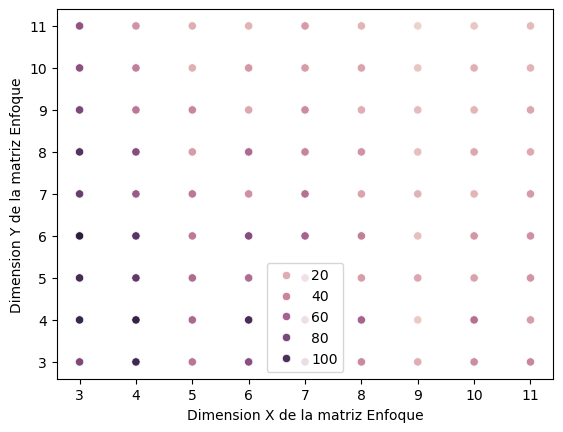

In [20]:
#Graficamos los resultados del loop
import seaborn as sns

sns.scatterplot(x=m_values, y=n_values, hue=resultados_values)
# Etiquetas de los ejes
plt.xlabel('Dimension X de la matriz Enfoque')
plt.ylabel('Dimension Y de la matriz Enfoque')

Podemos resumir que:
-  A partir de **dimensiones más grandes de 6x6 de matriz de enfoque**, la cantidad de frames enfocados baja considerablemente en comparacion con matrices más pequeñas.
- **Dimensiones debajo de 4x4** tienen más frames enfocados. Esto se entiende porque al abarcar menos área el promedio de la matriz de enfoque tiende a superar el threshold.
- La **dimension Y tiene mayor influencia que la dimension X**, como ejemplo vemos que para una matriz de Y=y y X=3 se tienen cantidad de frames enfocados cerca de 80 y 100. En este caso podemos entender que como el video contiene una pedalera extendida en el eje X, y el video se filma de manera oblicua, al aumentar la matriz en el eje Y, se empieza a incluir el suelo en la matriz de enfoque, y como la distancia focal entre la lente y los botones de la pedalera y la lente y el suelo es diferente, el FM tenderá a tener promedios más bajos, no superando el threshold.

<h2 style='color:orange;'> 2. Cambiar la métrica de enfoque, eligiendo uno de los algoritmos explicados en el apéndice de Analysis of focus measure operators in shapefrom focus</h2>

El algoritmo a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

In [12]:
#Vamos a usar el algoritmo de Brenner
#se basa en las diferencias de intensidad de los niveles de gris de la imagen

def brenner_focus_measure(image):
    """
    El metodo consiste en:
        1)calcular la diferencia de intensidad de cada pixel(i) de la imagen
            con respecto al píxel (i+2,j). 
        2) Elevar al cuadrado esa diferencia.
        3) Sumar todas las diferencias al cuadrado en una vecindad o sobre toda la imagen.        
        4) El valor obtenido es la metrica cuantificada que se debe usar 
            para determinar por comparación qué tan enfocada está el frame.
    
    image: Imagen en escala de grises.
    Retorna la métrica de enfoque.
    """
    # Convertir la imagen a float para evitar problemas de overflow
    image = image.astype(np.float32)
    
    # Aplicar el cálculo de Brenner (diferencia de píxeles con un desplazamiento de 2)
    shift_image = np.roll(image, -2, axis=0)  # desplaza -2 posiciones los elementos de la imagen en el eje y.
    brenner_measure = (image - shift_image) ** 2  #Calculamos el cuadrado
    
    # Sumamos las diferencias en toda la imagen
    return np.sum(brenner_measure)

def detect_max_focus(image, window_size=50, step_size=25):
    """
    Detecta las regiones de máximo enfoque en la imagen utilizando la métrica de Brenner.
    image: Imagen en escala de grises.
    window_size: Tamaño del frame de la sub-región a la cual se calcula el brenner measurement.
    step_size: Paso entre cada frame. Si es muy baja se ralentiza el video debido al 
        aumento de la complejidad computacional.
    """
    # Asegúrate de que la imagen está en escala de grises
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    height, width = image.shape
    max_focus_score = 0
    max_focus_coords = None

    # Iterar sobre la imagen en bloques de tamaño 'window_size'
    for y in range(0, height - window_size, step_size):
        for x in range(0, width - window_size, step_size):
            # Extraer la sub-región
            sub_image = image[y:y + window_size, x:x + window_size]
            
            # Calcular la métrica de enfoque de Brenner para la sub-región
            focus_score = brenner_focus_measure(sub_image)
            
            # Mantener el valor máximo y las coordenadas
            if focus_score > max_focus_score:
                max_focus_score = focus_score
                max_focus_coords = (x, y)
    
    return max_focus_coords, max_focus_score


Probamos el algoritmo

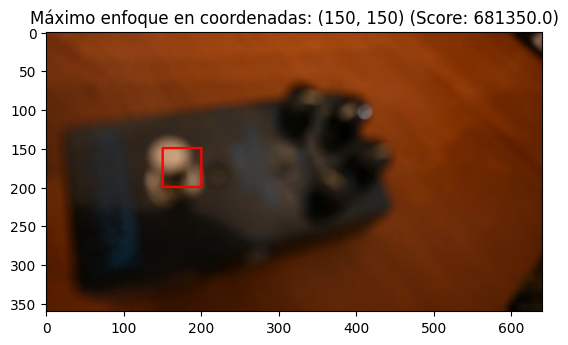

In [13]:
#1 Sobre la captura tomada anteriormente cuando la imagen esta desdenfocada

# Detectar la región con máximo enfoque
max_focus_coords, max_focus_score = detect_max_focus(unfocused_image, window_size=50, step_size=25)

# Dibujar un rectángulo en la región de máximo enfoque
x, y = max_focus_coords
cv2.rectangle(unfocused_image, (x, y), (x + 50, y + 50), (255, 0, 0), 2)

# Mostrar la imagen con la región de máximo enfoque marcada
plt.imshow(unfocused_image, cmap='gray')
plt.title(f"Máximo enfoque en coordenadas: {max_focus_coords} (Score: {max_focus_score})")
plt.show()


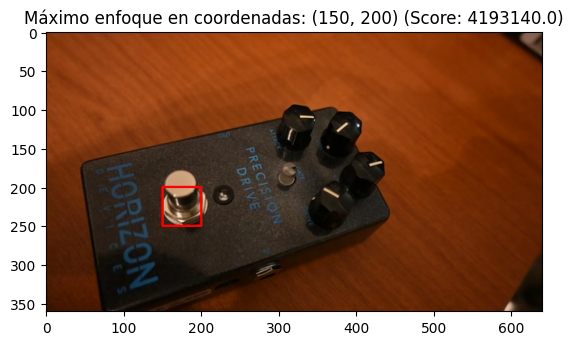

In [14]:
#2 Sobre la captura tomada anteriormente cuando la imagen esta enfocada

# Detectar la región con máximo enfoque
max_focus_coords, max_focus_score = detect_max_focus(focused_image, window_size=50, step_size=25)

# Dibujar un rectángulo en la región de máximo enfoque
x, y = max_focus_coords
cv2.rectangle(focused_image, (x, y), (x + 50, y + 50), (255, 0, 0), 2)

# Mostrar la imagen con la región de máximo enfoque marcada
plt.imshow(focused_image, cmap='gray')
plt.title(f"Máximo enfoque en coordenadas: {max_focus_coords} (Score: {max_focus_score})")
plt.show()


**Resumen**
Comparamos el brenner_focus_measurement entre la imagen enfocada original(4.193.140) y la imagen desenfocada (681.350) y vemos que la imagen enfocada tiene mayor score.

Ahora probamos el algoritmo sobre el video completo:

In [15]:
def process_video(video_path, output_path, window_size=50, step_size=25):
    """
    Procesa un video completo para detectar y marcar los puntos de máximo enfoque en cada frame.
    video_path: Ruta al video de entrada.
    output_path: Generaremos un video de salida. Ruta para el video procesado de salida. 
    window_size: Tamaño de la ventana de la sub-región para la detección de enfoque.
    step_size: Paso entre cada ventana de sub-región. Mas alto disminuye precision, si es bajo, 
        ralentiza la reproduccion debido a la mayor demanda de consumo computacional.
    """
    # Cargar el video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error al abrir el video")
        return

    # Obtener las dimensiones del video para guardar uno nuevo con las mismas caracteristicas
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    # Definir los parametros para guardar el video de salida
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Detectar la región con máximo enfoque
        max_focus_coords, max_focus_score = detect_max_focus(frame, window_size, step_size)

        if max_focus_coords:
            x, y = max_focus_coords
            # Coordenadas de la esquina superior izquierda del rectángulo
            x1 = int(x - window_size / 2)
            y1 = int(y - window_size / 2)

            # Coordenadas de la esquina inferior derecha del rectángulo
            x2 = int(x + window_size / 2)
            y2 = int(y + window_size / 2)

            # Dibujar el rectángulo centrado en (x, y)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Escribir el frame procesado en el archivo de salida
        out.write(frame)

        # Mostrar el frame procesado (opcional, para visualizar en tiempo real)
        cv2.imshow('Video Procesado', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Liberar recursos
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [16]:
# Procesamos el video
process_video('focus_video.mov', 'output_video.mp4', window_size=30, step_size=15)

<h2 style='color:orange;'>Puntos extra: Aplicar unsharp masking para expandir la zona de enfoque y devolver</h2>

fuente: https://en.wikipedia.org/wiki/Unsharp_masking

**Pasos para Aplicar Unsharp Masking:**
- Desenfoque de la Imagen: Aplicar el filtro de desenfoque Gaussiano a la imagen original.
- Crear la Máscara de Nitidez: Restar la imagen desenfocada de la imagen original.
- Combinar las Imágenes: Suma la máscara de nitidez a la imagen original, ajustando el nivel de realce.

In [17]:
#Definimos una funcion que cumpla estas tareas:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """
    Aplica unsharp masking a una imagen.
    
    image: Imagen de entrada
    kernel_size: Tamaño del kernel Gaussiano
    sigma: Desviación estándar del kernel Gaussiano
    amount: Intensidad del efecto de sharpening
    threshold: Umbral para aplicar el efecto
    return: Imagen con unsharp masking aplicado
    """
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

#Funcion para procesar el video y aplicar la unsharp_mask function definida arriba:
def process_video(input_path, output_path, focus_threshold=100, unsharp_amount=1.5):
    # Abrir el video de entrada
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error al abrir el video de entrada")
        return

    # Obtener propiedades del video
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Crear el objeto VideoWriter para el video de salida
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    #Definimos una variable que cuente cuantos a frames superaron el threshold
    masked_frames = 0 

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convertir el frame a escala de grises para el cálculo de enfoque
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #Usamos la funcion que usa la transformada de fourier para comparar con
        #un umbral, si el valor supera el umbral, no le aplico el unsharp masking
        #para evitar aplicar el unsharp_masking a los frames enfocados
        focus_measure = get_sharpness_measurement(gray)

        # Aplicar unsharp masking si el enfoque está por debajo del umbral
        if focus_measure < focus_threshold:
            frame = unsharp_mask(frame, amount=unsharp_amount)
            masked_frames += 1

        # Escribir el frame en el video de salida
        out.write(frame)

        # Mostrar el frame (opcional, para visualización durante el procesamiento)
        cv2.imshow('Frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    #Imprimimos cuantos frames fueron maskeados:
    print(masked_frames, 'Frames fueron afectados por el unsharp masking')
    # Liberar los recursos
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [18]:
# Probamos
input_video = 'focus_video.mov'
output_video = 'unsharped_video.mp4'
focus_threshold = 0.012 # Ajusta este valor según tus necesidades
unsharp_amount = 8 # Ajusta este valor para controlar la intensidad del sharpening

process_video(input_path = input_video, output_path = output_video, 
              focus_threshold = focus_threshold, unsharp_amount = unsharp_amount)

89 Frames fueron afectados por el unsharp masking


Ahora seria interesante calcular y comparar el nuevo video con la metrica del punto 1.1 sobre todo el video, a modo de cuantificar cuanto mejoró el unsharp masking el enfoque en el video original al video con unsharp masking aplicado.

In [19]:
video = cv2.VideoCapture('unsharped_video.mp4')

# Comprobar si el video se abrió correctamente
if not video.isOpened():
    print("Error al abrir el video")
    exit()

#Lista para almacenar los resultados de FM
resultados_um = []

# Leer el video frame por frame
while True:
    ret, frame = video.read()
    
    # Si no hay más frames, salir del bucle
    if not ret:
        break
    
    # Aplicar FM a cada frame
    valor = get_sharpness_measurement(frame)
    
    # Almacenar el resultado
    resultados_um.append(valor)
    
    # Salir si se presiona 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar el objeto de video y cerrar las ventanas
video.release()
cv2.destroyAllWindows()

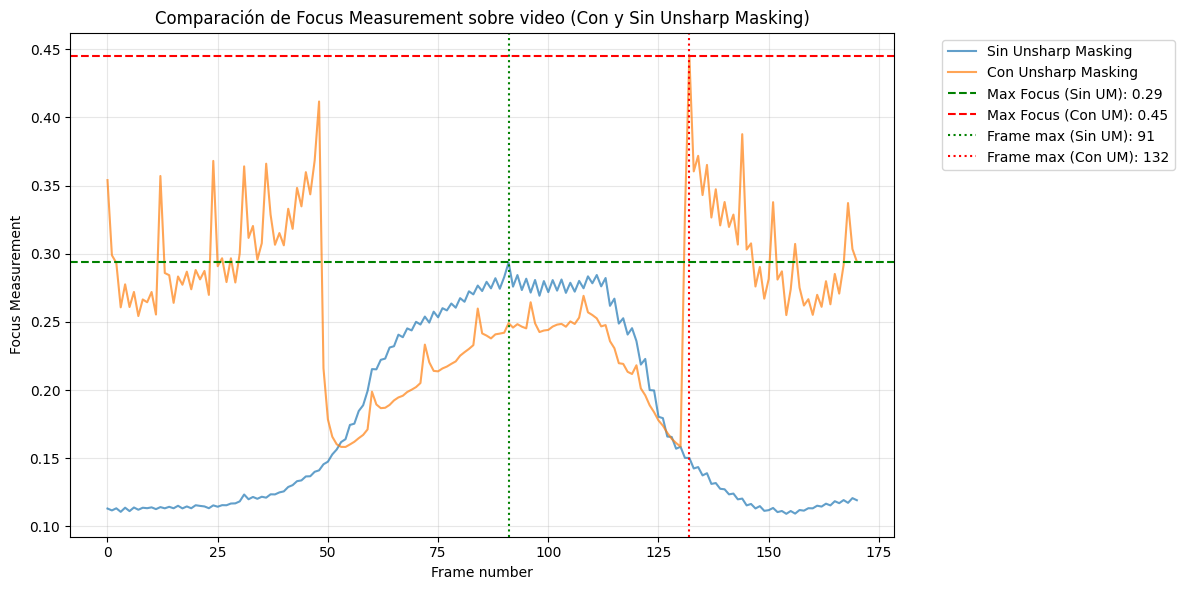

In [20]:
# Crear la figura y los subgráficos

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar ambas series de datos
ax.plot(resultados, label='Sin Unsharp Masking', alpha=0.7)
ax.plot(resultados_um, label='Con Unsharp Masking', alpha=0.7)

# Configurar el título y etiquetas de los ejes
ax.set_title('Comparación de Focus Measurement sobre video (Con y Sin Unsharp Masking)')
ax.set_xlabel('Frame number')
ax.set_ylabel('Focus Measurement')

# Añadir líneas para los valores máximos
ax.axhline(max(resultados), color='green', linestyle='--', 
           label=f'Max Focus (Sin UM): {max(resultados):.2f}')
ax.axhline(max(resultados_um), color='red', linestyle='--', 
           label=f'Max Focus (Con UM): {max(resultados_um):.2f}')

# Añadir líneas verticales para los frames con máximo focus measurement
ax.axvline(resultados.index(max(resultados)), color='green', linestyle=':', 
           label=f'Frame max (Sin UM): {resultados.index(max(resultados))}')
ax.axvline(resultados_um.index(max(resultados_um)), color='red', linestyle=':', 
           label=f'Frame max (Con UM): {resultados_um.index(max(resultados_um))}')

# Añadir cuadrícula
ax.grid(True, alpha=0.3)

# Añadir leyenda
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño para que la leyenda no se superponga con el gráfico
plt.tight_layout()


Vemos que para un valor de unsharp_amount = 8 se exagera la metrica de enfoque y la meseta que teniamos de enfoque máximo pasa a ser la mínima.
El objetivo es suavizar este grafico encontrando un unsharp_amount adecuado

In [237]:
# Probamos
input_video = 'focus_video.mov'
output_video = 'unsharped_video.mp4'
focus_threshold = 0.012 # Ajusta este valor según tus necesidades
unsharp_amount = 3.6  # Ajusta este valor para controlar la intensidad del sharpening

process_video(input_video, output_video, focus_threshold, unsharp_amount)

89 Frames fueron afectados por el unsharp masking


In [238]:
video = cv2.VideoCapture('unsharped_video.mp4')

# Comprobar si el video se abrió correctamente
if not video.isOpened():
    print("Error al abrir el video")
    exit()

#Lista para almacenar los resultados de FM
resultados_um = []

# Leer el video frame por frame
while True:
    ret, frame = video.read()
    
    # Si no hay más frames, salir del bucle
    if not ret:
        break
    
    # Aplicar FM al a cada frame
    valor = get_sharpness_measurement(frame)
    
    # Almacenar el resultado
    resultados_um.append(valor)
    
    # Salir si se presiona 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar el objeto de video y cerrar las ventanas
video.release()
cv2.destroyAllWindows()

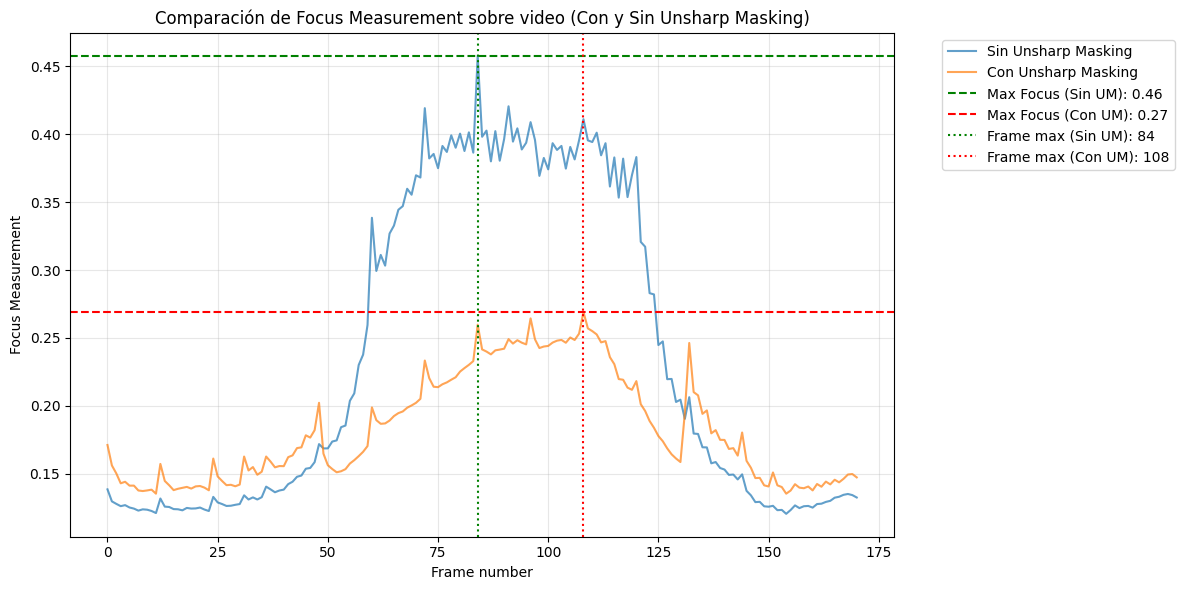

In [239]:
# Crear la figura y los subgráficos

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar ambas series de datos
ax.plot(resultados, label='Sin Unsharp Masking', alpha=0.7)
ax.plot(resultados_um, label='Con Unsharp Masking', alpha=0.7)

# Configurar el título y etiquetas de los ejes
ax.set_title('Comparación de Focus Measurement sobre video (Con y Sin Unsharp Masking)')
ax.set_xlabel('Frame number')
ax.set_ylabel('Focus Measurement')

# Añadir líneas para los valores máximos
ax.axhline(max(resultados), color='green', linestyle='--', 
           label=f'Max Focus (Sin UM): {max(resultados):.2f}')
ax.axhline(max(resultados_um), color='red', linestyle='--', 
           label=f'Max Focus (Con UM): {max(resultados_um):.2f}')

# Añadir líneas verticales para los frames con máximo focus measurement
ax.axvline(resultados.index(max(resultados)), color='green', linestyle=':', 
           label=f'Frame max (Sin UM): {resultados.index(max(resultados))}')
ax.axvline(resultados_um.index(max(resultados_um)), color='red', linestyle=':', 
           label=f'Frame max (Con UM): {resultados_um.index(max(resultados_um))}')

# Añadir cuadrícula
ax.grid(True, alpha=0.3)

# Añadir leyenda
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño para que la leyenda no se superponga con el gráfico
plt.tight_layout()

Vemos que con el valor de unsharp_amount de 3.6 la gráfica de focus measurement se ve más aplanada, sugiriendo una transición más suave entre los frames desenfocados a los enfocados. Aunque a los frames enfocados no se les aplicó el unsharp masking, se hubiese esperado que los valores de focus_measurement del video con unsharp masking aplicado en la zona de enfoque serían los mismos valores de focus_measurement que el video original, no sabemos por qué estos valores se redujeron, aunque aún son los mayores para la línea naranja.

Cabe recalcar que en los primeros frames, aunque se le haya aplicado unsharp masking, a la vista humana no se ven enfocado, esto es porque el método tampoco es capaz de enfocar imagenes que están muy fuera de foco.